# CHECK ML SUBSAMPLE SELECTION CRITERIA (RMS), AND THE VALUES FOR S4 SAMPLE AND ALTERNATIVE S4 SAMPLE

In this notebook we check if the pre-selection of ML subsample objects was carried out correctly. We also plot all the time series, as a double check.

## Modules and configuration

### Modules

In [720]:
import numpy as np
import pandas as pd

from IPython.display import clear_output

import pickle

from astropy.table import QTable
from astropy import units

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white", {'figure.figsize':(15,10)})

### Configuration

In [721]:
ML_PG_FILE = "../data/SELECTION_for_ML_CARM_VIS_objects_with_PG.csv" # To have additional metadata available for ML subsample
S4_FILE = "../data/RV_FINAL_ML_SyntheticDatasets_without_PG.csv"
ALT_S4_FILE = "../data/DATASETS_CESIUM/ALT_cesium_ML_FINAL_S4.csv"

ML_CURVES_FOLDER = "../data/CARM_VIS_RVs/"
ML_PREFIX = ""
ML_SUFFIX = ".avc.dat"

S4_CURVES_FOLDER = "../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/"
S4_PREFIX = ""
S4_SUFFIX = ".dat"

ALT_S4_CURVES_FOLDER = "../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_files/"
ALT_S4_PREFIX = ""
ALT_S4_SUFFIX = ".dat"


C_STARLIST_FILE = "../data/ML_MODELS/ML_pipeline_steps/compliant_stars.pickle"
# Will store the list of compliant stars
NC_STARLIST_FILE = "../data/ML_MODELS/ML_pipeline_steps/non-compliant_stars.pickle"
# Will store the list of non-compliant stars

IMG_FOLDER = "./img/"
IMG_FOLDER_LTE5 = "./img/ML_subsample_timeseries/RMS_lte_5/"
IMG_FOLDER_GT5 = "./img/ML_subsample_timeseries/RMS_gt_5/"

IMG_FOLDER_S4_C = "./img/S4_RV_curves/C/"
IMG_FOLDER_S4_NC = "./img/S4_RV_curves/NC/"
IMG_FOLDER_ALT_S4_C = "./img/ALT_S4_RV_curves/C/"
IMG_FOLDER_ALT_S4_NC = "./img/ALT_S4_RV_curves/NC/"

ML_FULL_RESULTS_FILE = "./RMS_Full_Results_by_Star_ML_subsample.csv"
ML_RMS_DESCRIBE_RESULTS = "./RMS_Describe_results_ML_subsample.csv"

S4_FULL_RESULTS_FILE = "./RMS_Full_Results_by_Star_S4_sample.csv"
S4_RMS_DESCRIBE_RESULTS = "./RMS_Describe_results_S4_sample.csv"

ALT_S4_FULL_RESULTS_FILE = "./RMS_Full_Results_by_Star_ALT_S4_sample.csv"
ALT_S4_RMS_DESCRIBE_RESULTS = "./RMS_Describe_results_ALT_S4_sample.csv"

GLOBAL_FULL_RESULTS = "./RMS_Full_Results_by_Star_ML_S4_ALTS4.csv"


### Functions

In [722]:
def calculate_RMSE(rvfile=None):
    '''Calculates RMSE of a Time Series stored in the file passed as parameter, with two approaches:
    - With astropy module
    - With sklearn.metrics module (both RMS and weighted RMS)
    Returns the three values
    '''
    if rvfile is None:
        return None
    else:
        # Read QTtable:
        astpy = QTable.read(rvfile,
                            format='ascii', delimiter=' ',
                            names=['BJD', 'RV', 'RV_error'],
                            units=[units.d, units.m/units.s, units.m/units.s])
        # Extract the rmse (std) value:
        astropy_std = units.Quantity(astpy['RV'].info(['stats'], out=None)['std']).value
       
        # Read pandas DataFrame:
        df = pd.read_csv(rvfile, sep=' ', decimal='.',
                         names=['BJD', 'RV', 'RV_error'])
        # Calculate weights with the 'error_RV' column:
        df['weights'] = df['RV_error'].map(lambda x: 1.0 / x**x)
        sklearn_rmse = mean_squared_error(y_true=df['RV'] , y_pred=np.zeros(len(df)),
                                          squared=False)
        sklearn_wrmse = mean_squared_error(y_true=df['RV'] , y_pred=np.zeros(len(df)),
                                           sample_weights=df['weights'],
                                           squared=False)
        return astropy_std, sklearn_rmse, sklearn_wrmse
        

In [723]:
def calculate_std_astropy(rvfile=None):
    '''Calculates the 'std' value of a Time series stored in the file passed as parameter, 
    with astropy module.
    Returns just the value (i.e. not the 'Quantity' type)
    '''
    if rvfile is None:
        return None
    else:
        # Read QTtable:
        astpy = QTable.read(rvfile,
                            format='ascii', delimiter=' ',
                            names=['BJD', 'RV', 'RV_error'],
                            units=[units.d, units.m/units.s, units.m/units.s])
        # Extract the rmse (std) value:
        astropy_std = units.Quantity(astpy['RV'].info(['stats'], out=None)['std']).value
        return astropy_std
        

In [724]:
def calculate_rmse_sk(rvfile=None):
    '''Calculates the RMSE of a Time series stored in the file passed as parameter, 
    with the sklearn.metrics module.
    Returns the value
    '''
    if rvfile is None:
        return None
    else:
        # Read pandas DataFrame:
        df = pd.read_csv(rvfile, sep=' ', decimal='.',
                         names=['BJD', 'RV', 'RV_error'])
        sklearn_rmse = mean_squared_error(y_true=df['RV'] , y_pred=np.zeros(len(df)),
                                          squared=False)
        return sklearn_rmse
        

In [725]:
def calculate_weighted_rmse_sk(rvfile=None):
    '''Calculates the weigthed RMSE of a Time series stored in the file passed as parameter, 
    with the sklearn.metrics module.
    Returns the value
    '''
    if rvfile is None:
        return None
    else:
        # Read pandas DataFrame:
        df = pd.read_csv(rvfile, sep=' ', decimal='.',
                         names=['BJD', 'RV', 'RV_error'])
        # Calculate weights with the 'error_RV' column:
        df['weights'] = df['RV_error'].map(lambda x: 1.0 / x**x)
        sklearn_wrmse = mean_squared_error(y_true=df['RV'] , y_pred=np.zeros(len(df)),
                                           sample_weight=df['weights'],
                                           squared=False)
        return sklearn_wrmse
        

In [726]:
def draw_curves(times, values, value_label, title, ymarks=[], fig_filename=None):
    '''Draws several time series curves in the same plot'''
    '''Had to be modified for new seaborn version --- Needs improvement'''
    # Plots and saves the figure
    #kwargs = dict({'ms': 2.0})
    plt.figure(figsize=(10,7))
    plt.title(title, fontsize=16)
    #plt.grid(axis='both', alpha=0.75)
    plt.xlabel("Time [BJD]", fontsize=12)
    plt.ylabel(value_label, fontsize=12)
    for i in range(0, len(times)):
        data = pd.DataFrame(data={'Time': times[i], 'RV': values[i]})
        g = sns.scatterplot(data=data, x='Time', y='RV')
        #g = sns.scatterplot(times[i], values[i], label=labels[i])
    for ymark in ymarks:
        plt.axhline(y=ymark, c='darkred', ls=":")
    #plt.legend();
    #ylabels = ['{:,.2f}'.format(y) for y in g.get_yticks()]
    #g.set_yticklabels(ylabels)
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='jpg', bbox_inches='tight')

In [727]:
def multi_compare_dist(data, d_labels, varname=None, fig_title=None, fig_filename=None,
                       kde=False, hist_fill=True):
    '''Plots and saves multiple overlapped histograms.
    Changed to use the new functions, instead of the deprecated "distplot"'''
    # Plots and saves the figure
    #kwargs = dict(kde_kws={'linewidth': 2})
    #kwargs = dict(hist_kws={'alpha': .30, 'histtype': 'step', 'linewidth': 2, 'fill': hist_fill},
    #              kde_kws={'linewidth': 2})
    #kwargs = dict(hist_kws={'alpha': .30, 'histtype': 'step', 'linewidth': 2, 'fill': hist_fill})
    plt.figure(figsize=(10,7))
    axes = []
    for i in range(0, len(d_labels)):
        new_axis = sns.histplot(data, x=d_labels[i], kde=kde, fill=hist_fill, alpha=0.25, label=d_labels[i])
        #new_axis = sns.distplot(d_list[i], label=d_labels[i], kde=kde, **kwargs)
        #new_axis = sns.displot(d_list[i], label=d_labels[i], kind=kind, kde=kde)
        axes.append(new_axis)
        #if kde == False:
        #    axes[i].get_lines()[0].remove()
    if varname is None:
        axes[0].set_xlabel("Value", fontsize=12)
    else:
        axes[0].set_xlabel(varname, fontsize=12)
    #plt.xlim(0,100)
    if fig_title is None:
        plt.title("Comparison of distributions", fontsize=16)
    else:
        plt.title(fig_title, fontsize=16)
    #plt.grid(axis='x', alpha=0.75)
    plt.ylabel('Frequency of occurrence', fontsize=12)
    #plt.legend(loc='upper right');
    plt.legend(loc='best');
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='jpg')

## Load data

### Load ML subsample data

In [728]:
df = pd.read_csv(ML_PG_FILE, sep=',', decimal='.')
df

,Karmn,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,l_J2016_deg,b_J2016_deg,...,WF_offset_PG_TESS,WF_e_offset_PG_TESS,WF_FAP_PG_TESS,WF_valid_PG_TESS,WF_error_PG_TESS,WF_elapsed_time_PG_TESS,WF_plain_file_TESS,WF_fig_file_TESS,PG_file_RV,PG_file_TESS
0,J23505-095,LP 763-012,-,4367,357.634705,-9.560964,23:50:31.64,-09:33:32.7,80.777067,-67.303426,...,1000.000122,9.022946e-07,1.0,1.0,NaN,132.607176,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23505-09...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23505-095_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23505-095_RV_PG.dat
1,J23492+024,BR Psc,-,908,357.306604,2.396918,23:49:12.53,+02:24:04.4,93.567467,-56.885396,...,NaN,NaN,NaN,0.0,Not recognized as a supported data product:\nn...,0.001995,NaN,NaN,../data/CARM_VIS_RVs_PGs/J23492+024_RV_PG.dat,NaN
2,J23431+365,GJ 1289,-,1289,355.781509,36.536310,23:43:06.31,+36:32:13.1,107.922839,-24.336479,...,999.999512,4.306074e-06,1.0,1.0,NaN,97.939914,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23431+36...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23431+365_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23431+365_RV_PG.dat
3,J23419+441,HH And,-,905,355.480015,44.170376,23:41:55.04,+44:10:38.8,109.989338,-16.947350,...,NaN,NaN,NaN,0.0,Not recognized as a supported data product:\nn...,0.000998,NaN,NaN,../data/CARM_VIS_RVs_PGs/J23419+441_RV_PG.dat,NaN
4,J23381-162,G 273-093,-,4352,354.532687,-16.236514,23:38:08.16,-16:14:10.2,61.845437,-69.825220,...,1000.000122,9.022946e-07,1.0,1.0,NaN,136.603404,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23381-16...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23381-162_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23381-162_RV_PG.dat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,J00184+440,GQ And,B,15B,4.625301,44.028745,00:18:25.82,+44:01:38.1,116.700222,-18.444111,...,NaN,NaN,NaN,0.0,Not recognized as a supported data product:\nn...,0.000998,NaN,NaN,../data/CARM_VIS_RVs_PGs/J00184+440_RV_PG.dat,NaN
229,J00183+440,GX And,A,15A,4.613226,44.024787,00:18:22.88,+44:01:22.6,116.690592,-18.446865,...,999.999756,2.134945e-06,1.0,1.0,NaN,191.241441,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J00183+44...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J00183+440_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J00183+440_RV_PG.dat
230,J00162+198E,LP 404-062,B,1006B,4.070651,19.860692,00:16:16.15,+19:51:50.5,111.738263,-42.245679,...,NaN,NaN,NaN,0.0,Not recognized as a supported data product:\nn...,0.001995,NaN,NaN,../data/CARM_VIS_RVs_PGs/J00162+198E_RV_PG.dat,NaN
231,J00067-075,GJ 1002,-,1002,1.676350,-7.546475,00:06:43.20,-07:32:17.0,92.444693,-67.730511,...,NaN,NaN,NaN,0.0,Not recognized as a supported data product:\nn...,0.001995,NaN,NaN,../data/CARM_VIS_RVs_PGs/J00067-075_RV_PG.dat,NaN


In [729]:
print(list(df.columns))

['Karmn', 'Name', 'Comp', 'GJ', 'RA_J2016_deg', 'DE_J2016_deg', 'RA_J2000', 'DE_J2000', 'l_J2016_deg', 'b_J2016_deg', 'Ref01', 'SpT', 'SpTnum', 'Ref02', 'Teff_K', 'eTeff_K', 'logg', 'elogg', '[Fe/H]', 'e[Fe/H]', 'Ref03', 'L_Lsol', 'eL_Lsol', 'Ref04', 'R_Rsol', 'eR_Rsol', 'Ref05', 'M_Msol', 'eM_Msol', 'Ref06', 'muRA_masa-1', 'emuRA_masa-1', 'muDE_masa-1', 'emuDE_masa-1', 'Ref07', 'pi_mas', 'epi_mas', 'Ref08', 'd_pc', 'ed_pc', 'Ref09', 'Vr_kms-1', 'eVr_kms-1', 'Ref10', 'ruwe', 'Ref11', 'U_kms-1', 'eU_kms-1', 'V_kms-1', 'eV_kms-1', 'W_kms-1', 'eW_kms-1', 'Ref12', 'sa_m/s/a', 'esa_m/s/a', 'Ref13', 'SKG', 'Ref14', 'SKG_lit', 'Ref14_lit', 'Pop', 'Ref15', 'vsini_flag', 'vsini_kms-1', 'evsini_kms-1', 'Ref16', 'P_d', 'eP_d', 'Ref17', 'pEWHalpha_A', 'epEWHalpha_A', 'Ref18', 'log(LHalpha/Lbol)', 'elog(LHalpha/Lbol)', 'Ref19', '1RXS', 'CRT_s-1', 'eCRT_s-1', 'HR1', 'eHR1', 'HR2', 'eHR2', 'Flux_X_E-13_ergcm-2s-1', 'eFlux_X_E-13_ergcm-2s-1', 'LX/LJ', 'eLX/LJ', 'Ref20', 'Activity', 'Ref21', 'FUV_mag',

### Load S4 sample data

In [730]:
s4 = pd.read_csv(S4_FILE, sep=',', decimal='.')
s4

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,S1_Ps,S1_Tobs,S2_errorRV_dist_idx,...,S3_Ps_median,S3_Ps_stdev,S3_NumPoints,S4_errorRV_mean,S4_errorRV_median,S4_errorRV_stdev,S1_file,S2_file,S3_file,S4_file
0,Star-00000,True,10.33,1.14,0.0,2.457582e+06,0.90,0.0016,100.0,209,...,12.486990,423.473643,11,1.539091,1.370,0.466271,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
1,Star-00001,True,14.92,1.30,0.0,2.457522e+06,0.02,0.0016,100.0,78,...,3.807657,30.022301,62,1.550806,1.395,0.434698,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
2,Star-00002,False,0.00,0.00,0.0,2.457549e+06,0.00,0.0016,100.0,218,...,10.074961,40.909038,66,1.459242,1.245,0.581178,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
3,Star-00003,False,0.00,0.00,0.0,2.457460e+06,0.00,0.0016,100.0,28,...,15.987473,56.735394,52,1.965385,1.570,0.980136,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
4,Star-00004,True,28.74,0.90,0.0,2.457451e+06,0.29,0.0016,100.0,6,...,26.947282,162.151502,24,1.342917,1.275,0.285504,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Star-00995,False,0.00,0.00,0.0,2.457504e+06,0.00,0.0016,100.0,25,...,25.953213,90.327010,10,3.286000,2.290,1.683533,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
996,Star-00996,False,0.00,0.00,0.0,2.457673e+06,0.00,0.0016,100.0,203,...,7.031455,139.291882,6,1.671667,1.405,0.811776,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
997,Star-00997,False,0.00,0.00,0.0,2.458634e+06,0.00,0.0016,100.0,50,...,2.002482,16.384223,364,1.656484,1.540,0.509895,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
998,Star-00998,False,0.00,0.00,0.0,2.457397e+06,0.00,0.0016,100.0,197,...,9.023501,50.228453,78,8.531538,6.655,3.790626,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...


In [731]:
print(list(s4.columns))

['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', 'S1_Ps', 'S1_Tobs', 'S2_errorRV_dist_idx', 'S2_errorRV_dist_name', 'S2_errorRV_dist_loc', 'S2_errorRV_dist_scale', 'S2_errorRV_mean', 'S2_errorRV_median', 'S2_errorRV_stdev', 'S3_sampling_idx', 'S3_Tobs', 'S3_Ps_mean', 'S3_Ps_median', 'S3_Ps_stdev', 'S3_NumPoints', 'S4_errorRV_mean', 'S4_errorRV_median', 'S4_errorRV_stdev', 'S1_file', 'S2_file', 'S3_file', 'S4_file']


### Load alternative S4 sample data

In [732]:
alt_s4 = pd.read_csv(ALT_S4_FILE, sep=',', decimal='.')
alt_s4

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,CARMENES_source_idx,CARMENES_Ref_star,Tobs,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
0,ALT_Star-00000,True,8.0,0.1,0.0,0.0,0.0,0,J23505-095,1581.691279,...,0.977504,0.644803,-0.063853,0.000275,0.924870,0.618087,1.117089,0.765823,2.172233,0.386550
1,ALT_Star-00001,False,0.0,0.0,0.0,0.0,0.0,0,J23505-095,1581.691279,...,0.907370,0.673338,-0.041002,-0.000230,0.954109,0.875214,1.706731,1.360577,2.177206,0.526797
2,ALT_Star-00002,True,8.0,0.2,0.0,0.0,0.0,0,J23505-095,1581.691279,...,0.919256,0.698475,-0.041303,0.000604,0.887896,0.729239,1.413223,1.231405,2.078944,0.487139
3,ALT_Star-00003,False,0.0,0.0,0.0,0.0,0.0,0,J23505-095,1581.691279,...,1.016947,0.668096,-0.047139,0.000606,1.013569,0.780295,1.715909,1.142045,1.974111,0.637595
4,ALT_Star-00004,True,8.0,0.4,0.0,0.0,0.0,0,J23505-095,1581.691279,...,0.840501,0.686223,-0.180135,0.000507,0.893944,1.162059,1.284404,1.307339,1.680354,0.470151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9315,ALT_Star-09315,False,0.0,0.0,0.0,0.0,0.0,232,J00051+457,693.216479,...,0.933450,0.664869,-0.031495,-0.001853,0.897137,0.566383,2.059322,1.033898,2.580835,0.436217
9316,ALT_Star-09316,True,64.0,0.8,0.0,0.0,0.0,232,J00051+457,693.216479,...,0.881823,0.661800,0.086806,-0.001466,1.303187,0.713493,1.704641,1.274262,1.968759,0.573645
9317,ALT_Star-09317,False,0.0,0.0,0.0,0.0,0.0,232,J00051+457,693.216479,...,0.961473,0.480527,0.092379,0.001305,1.245433,0.685681,1.369369,1.027027,2.075335,0.467850
9318,ALT_Star-09318,True,64.0,1.6,0.0,0.0,0.0,232,J00051+457,693.216479,...,0.854645,0.615918,-0.008289,-0.000258,1.019424,0.628964,1.487889,0.851211,2.155080,0.303535


In [733]:
print(list(alt_s4.columns))

['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', 'CARMENES_source_idx', 'CARMENES_Ref_star', 'Tobs', 'Ps_mean', 'Ps_median', 'Ps_stdev', 'NumPoints', 'errorRV_dist_loc', 'errorRV_dist_scale', 'errorRV_mean', 'errorRV_median', 'errorRV_stdev', 'S4_ALT_file', 'VALID_RECORD', 'all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin', 'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin', 'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2', 'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4', 'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4', 'all_times_nhist_peak_3_to_4', 'all_times_nhist_peak_val', 'avg_double_to_single_step', 'avg_err', 'avgt', 'cad_probs_1', 'cad_probs_10', 'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50', 'cad_probs_100', 'cad_probs_500', 'cad_probs_1000', 'cad_probs_5000', 'cad_probs_10000', 'cad_probs_50000', 'cad_probs_100000', 'cad_probs_500000', 'cad_probs_1000000', 'cad_probs_5000000', '

#### FIX: correct star names if needed

In [734]:
alt_s4['ID'] = alt_s4['ID'].map(lambda x: x if x[:4] == "ALT_" else "ALT_" + x)
alt_s4

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,CARMENES_source_idx,CARMENES_Ref_star,Tobs,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
0,ALT_Star-00000,True,8.0,0.1,0.0,0.0,0.0,0,J23505-095,1581.691279,...,0.977504,0.644803,-0.063853,0.000275,0.924870,0.618087,1.117089,0.765823,2.172233,0.386550
1,ALT_Star-00001,False,0.0,0.0,0.0,0.0,0.0,0,J23505-095,1581.691279,...,0.907370,0.673338,-0.041002,-0.000230,0.954109,0.875214,1.706731,1.360577,2.177206,0.526797
2,ALT_Star-00002,True,8.0,0.2,0.0,0.0,0.0,0,J23505-095,1581.691279,...,0.919256,0.698475,-0.041303,0.000604,0.887896,0.729239,1.413223,1.231405,2.078944,0.487139
3,ALT_Star-00003,False,0.0,0.0,0.0,0.0,0.0,0,J23505-095,1581.691279,...,1.016947,0.668096,-0.047139,0.000606,1.013569,0.780295,1.715909,1.142045,1.974111,0.637595
4,ALT_Star-00004,True,8.0,0.4,0.0,0.0,0.0,0,J23505-095,1581.691279,...,0.840501,0.686223,-0.180135,0.000507,0.893944,1.162059,1.284404,1.307339,1.680354,0.470151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9315,ALT_Star-09315,False,0.0,0.0,0.0,0.0,0.0,232,J00051+457,693.216479,...,0.933450,0.664869,-0.031495,-0.001853,0.897137,0.566383,2.059322,1.033898,2.580835,0.436217
9316,ALT_Star-09316,True,64.0,0.8,0.0,0.0,0.0,232,J00051+457,693.216479,...,0.881823,0.661800,0.086806,-0.001466,1.303187,0.713493,1.704641,1.274262,1.968759,0.573645
9317,ALT_Star-09317,False,0.0,0.0,0.0,0.0,0.0,232,J00051+457,693.216479,...,0.961473,0.480527,0.092379,0.001305,1.245433,0.685681,1.369369,1.027027,2.075335,0.467850
9318,ALT_Star-09318,True,64.0,1.6,0.0,0.0,0.0,232,J00051+457,693.216479,...,0.854645,0.615918,-0.008289,-0.000258,1.019424,0.628964,1.487889,0.851211,2.155080,0.303535


## Analyze RMS of the CARMENES ML subsample RV curves

In [735]:
results = df[['Karmn', 'wrms_RV', 'rv_file']].copy()
results.head()

,Karmn,wrms_RV,rv_file
0,J23505-095,3.362607,../data/CARM_VIS_RVs/J23505-095.avc.dat
1,J23492+024,2.183867,../data/CARM_VIS_RVs/J23492+024.avc.dat
2,J23431+365,2.795865,../data/CARM_VIS_RVs/J23431+365.avc.dat
3,J23419+441,2.532704,../data/CARM_VIS_RVs/J23419+441.avc.dat
4,J23381-162,2.405056,../data/CARM_VIS_RVs/J23381-162.avc.dat


In [736]:
results[['astropy_std', 'sklearn_RMSE', 'sklearn_weigthed_RMSE']] = np.nan
results.head()

,Karmn,wrms_RV,rv_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE
0,J23505-095,3.362607,../data/CARM_VIS_RVs/J23505-095.avc.dat,NaN,NaN,NaN
1,J23492+024,2.183867,../data/CARM_VIS_RVs/J23492+024.avc.dat,NaN,NaN,NaN
2,J23431+365,2.795865,../data/CARM_VIS_RVs/J23431+365.avc.dat,NaN,NaN,NaN
3,J23419+441,2.532704,../data/CARM_VIS_RVs/J23419+441.avc.dat,NaN,NaN,NaN
4,J23381-162,2.405056,../data/CARM_VIS_RVs/J23381-162.avc.dat,NaN,NaN,NaN


### Examples table read

In [737]:
astpy_example = QTable.read(ML_CURVES_FOLDER + 'J23505-095' + ML_SUFFIX,
                            format='ascii', delimiter=' ',
                            names=['BJD', 'RV', 'RV_error'],
                            units=[units.d, units.m/units.s, units.m/units.s])
astpy_example

BJD,RV,RV_error
d,m / s,m / s
float64,float64,float64
2457594.6752628055,-3.165321775715289,2.4501020106724356
2457606.632775929,-0.9709932775851982,1.765530721327811
2457642.554054242,-3.447762220282078,1.665417271356808
2457652.604834333,-4.520120204052661,1.8581105647983571
2457655.474631772,-7.9064143401873865,1.3802996130972698
2457689.4381131977,-7.833849033291345,1.5811741634495138
2458092.3815138745,-5.410401470918138,1.303100295768838
2458095.3300755816,-2.2579824256354364,1.5565582987408204


In [738]:
astpy_example['RV'].info(['stats'], out=None)['std']

'3.58753 m / s'

In [739]:
units.Quantity(astpy_example['RV'].info(['stats'], out=None)['std'])

<Quantity 3.58753 m / s>

In [740]:
units.Quantity(astpy_example['RV'].info(['stats'], out=None)['std']).value

3.58753

In [741]:
df_example = pd.read_csv(ML_CURVES_FOLDER + 'J23505-095' + ML_SUFFIX,
                         sep=' ', decimal='.',
                         names=['BJD', 'RV', 'RV_error'])
df_example

,BJD,RV,RV_error
0,2.457595e+06,-3.165322,2.450102
1,2.457607e+06,-0.970993,1.765531
2,2.457643e+06,-3.447762,1.665417
3,2.457653e+06,-4.520120,1.858111
4,2.457655e+06,-7.906414,1.380300
...,...,...,...
66,2.459114e+06,0.944434,3.954870
67,2.459115e+06,0.312324,2.048543
68,2.459116e+06,4.321023,2.922240
69,2.459146e+06,3.254575,1.689112


In [742]:
df_example['weights'] = df_example['RV_error'].map(lambda x: 1.0 / x)
df_example

,BJD,RV,RV_error,weights
0,2.457595e+06,-3.165322,2.450102,0.408146
1,2.457607e+06,-0.970993,1.765531,0.566402
2,2.457643e+06,-3.447762,1.665417,0.600450
3,2.457653e+06,-4.520120,1.858111,0.538181
4,2.457655e+06,-7.906414,1.380300,0.724480
...,...,...,...,...
66,2.459114e+06,0.944434,3.954870,0.252853
67,2.459115e+06,0.312324,2.048543,0.488152
68,2.459116e+06,4.321023,2.922240,0.342203
69,2.459146e+06,3.254575,1.689112,0.592027


In [743]:
np.sqrt(mean_squared_error(y_true=df_example['RV'] , y_pred=np.zeros(len(df_example))))

3.5927430680676906

In [744]:
np.sqrt(mean_squared_error(y_true=df_example['RV'] , y_pred=np.zeros(len(df_example)),
                           sample_weight=df_example['weights']))

3.4668234666670887

### Populate the RMSE values (ML subsample)

In [745]:
results

,Karmn,wrms_RV,rv_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE
0,J23505-095,3.362607,../data/CARM_VIS_RVs/J23505-095.avc.dat,NaN,NaN,NaN
1,J23492+024,2.183867,../data/CARM_VIS_RVs/J23492+024.avc.dat,NaN,NaN,NaN
2,J23431+365,2.795865,../data/CARM_VIS_RVs/J23431+365.avc.dat,NaN,NaN,NaN
3,J23419+441,2.532704,../data/CARM_VIS_RVs/J23419+441.avc.dat,NaN,NaN,NaN
4,J23381-162,2.405056,../data/CARM_VIS_RVs/J23381-162.avc.dat,NaN,NaN,NaN
...,...,...,...,...,...,...
228,J00184+440,2.311629,../data/CARM_VIS_RVs/J00184+440.avc.dat,NaN,NaN,NaN
229,J00183+440,2.617721,../data/CARM_VIS_RVs/J00183+440.avc.dat,NaN,NaN,NaN
230,J00162+198E,2.861697,../data/CARM_VIS_RVs/J00162+198E.avc.dat,NaN,NaN,NaN
231,J00067-075,2.440083,../data/CARM_VIS_RVs/J00067-075.avc.dat,NaN,NaN,NaN


In [746]:
results['astropy_std'] = results['rv_file'].map(lambda x: calculate_std_astropy(x))
results['sklearn_RMSE'] = results['rv_file'].map(lambda x: calculate_rmse_sk(x))
results['sklearn_weigthed_RMSE'] = results['rv_file'].map(lambda x: calculate_weighted_rmse_sk(x))
results

,Karmn,wrms_RV,rv_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE
0,J23505-095,3.362607,../data/CARM_VIS_RVs/J23505-095.avc.dat,3.58753,3.592743,3.303345
1,J23492+024,2.183867,../data/CARM_VIS_RVs/J23492+024.avc.dat,2.50473,2.505042,2.148606
2,J23431+365,2.795865,../data/CARM_VIS_RVs/J23431+365.avc.dat,2.63638,2.636442,2.745168
3,J23419+441,2.532704,../data/CARM_VIS_RVs/J23419+441.avc.dat,2.60045,2.600656,2.539899
4,J23381-162,2.405056,../data/CARM_VIS_RVs/J23381-162.avc.dat,3.72518,3.726117,2.113373
...,...,...,...,...,...,...
228,J00184+440,2.311629,../data/CARM_VIS_RVs/J00184+440.avc.dat,2.50925,2.517105,2.290163
229,J00183+440,2.617721,../data/CARM_VIS_RVs/J00183+440.avc.dat,3.02057,3.042922,2.596425
230,J00162+198E,2.861697,../data/CARM_VIS_RVs/J00162+198E.avc.dat,3.05104,3.072807,2.845389
231,J00067-075,2.440083,../data/CARM_VIS_RVs/J00067-075.avc.dat,2.65376,2.658844,2.431129


In [747]:
results.rename(columns={'wrms_RV': 'gls.py_wrms'},
               inplace=True)
results

,Karmn,gls.py_wrms,rv_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE
0,J23505-095,3.362607,../data/CARM_VIS_RVs/J23505-095.avc.dat,3.58753,3.592743,3.303345
1,J23492+024,2.183867,../data/CARM_VIS_RVs/J23492+024.avc.dat,2.50473,2.505042,2.148606
2,J23431+365,2.795865,../data/CARM_VIS_RVs/J23431+365.avc.dat,2.63638,2.636442,2.745168
3,J23419+441,2.532704,../data/CARM_VIS_RVs/J23419+441.avc.dat,2.60045,2.600656,2.539899
4,J23381-162,2.405056,../data/CARM_VIS_RVs/J23381-162.avc.dat,3.72518,3.726117,2.113373
...,...,...,...,...,...,...
228,J00184+440,2.311629,../data/CARM_VIS_RVs/J00184+440.avc.dat,2.50925,2.517105,2.290163
229,J00183+440,2.617721,../data/CARM_VIS_RVs/J00183+440.avc.dat,3.02057,3.042922,2.596425
230,J00162+198E,2.861697,../data/CARM_VIS_RVs/J00162+198E.avc.dat,3.05104,3.072807,2.845389
231,J00067-075,2.440083,../data/CARM_VIS_RVs/J00067-075.avc.dat,2.65376,2.658844,2.431129


In [748]:
len(results)

233

In [749]:
results['Compliant'] = (results['gls.py_wrms'] <= 5.0) & (results['astropy_std'] <= 5.0) & \
    (results['sklearn_RMSE'] <= 5.0) & (results['sklearn_weigthed_RMSE'] <= 5.0)
results

,Karmn,gls.py_wrms,rv_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE,Compliant
0,J23505-095,3.362607,../data/CARM_VIS_RVs/J23505-095.avc.dat,3.58753,3.592743,3.303345,True
1,J23492+024,2.183867,../data/CARM_VIS_RVs/J23492+024.avc.dat,2.50473,2.505042,2.148606,True
2,J23431+365,2.795865,../data/CARM_VIS_RVs/J23431+365.avc.dat,2.63638,2.636442,2.745168,True
3,J23419+441,2.532704,../data/CARM_VIS_RVs/J23419+441.avc.dat,2.60045,2.600656,2.539899,True
4,J23381-162,2.405056,../data/CARM_VIS_RVs/J23381-162.avc.dat,3.72518,3.726117,2.113373,True
...,...,...,...,...,...,...,...
228,J00184+440,2.311629,../data/CARM_VIS_RVs/J00184+440.avc.dat,2.50925,2.517105,2.290163,True
229,J00183+440,2.617721,../data/CARM_VIS_RVs/J00183+440.avc.dat,3.02057,3.042922,2.596425,True
230,J00162+198E,2.861697,../data/CARM_VIS_RVs/J00162+198E.avc.dat,3.05104,3.072807,2.845389,True
231,J00067-075,2.440083,../data/CARM_VIS_RVs/J00067-075.avc.dat,2.65376,2.658844,2.431129,True


#### Save the full results

In [750]:
results.to_csv(ML_FULL_RESULTS_FILE, sep=',', decimal='.', index=False)

### Check results (ML subsample)

In [751]:
res_stats = results.describe()
res_stats

,gls.py_wrms,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE
count,233.000000,233.000000,233.000000,233.000000
mean,3.021702,3.450157,3.498164,2.949381
std,0.879263,1.442417,1.514759,0.870284
min,0.666710,0.892750,0.912695,0.583486
25%,2.365640,2.547090,2.586359,2.344105
50%,2.812982,3.109600,3.140789,2.806207
75%,3.593585,3.979130,4.036025,3.512055
max,4.977859,13.865100,14.749404,4.984955


#### Save results

In [752]:
res_stats.to_csv(ML_RMS_DESCRIBE_RESULTS, sep=',', decimal='.')

In [753]:
gt5 = results[results['Compliant'] == False].reset_index()
gt5

,index,Karmn,gls.py_wrms,rv_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE,Compliant
0,7,J23245+578,4.930567,../data/CARM_VIS_RVs/J23245+578.avc.dat,5.14270,5.174871,4.874843,False
1,13,J22114+409,4.756440,../data/CARM_VIS_RVs/J22114+409.avc.dat,4.96928,5.020880,4.579901,False
2,17,J21474+627,4.393431,../data/CARM_VIS_RVs/J21474+627.avc.dat,5.31026,5.313404,4.176913,False
3,22,J21164+025,4.974812,../data/CARM_VIS_RVs/J21164+025.avc.dat,5.22142,5.241918,4.984955,False
4,33,J19242+755,4.504466,../data/CARM_VIS_RVs/J19242+755.avc.dat,5.33594,5.336219,4.088211,False
5,40,J18580+059,4.472404,../data/CARM_VIS_RVs/J18580+059.avc.dat,7.72888,7.832712,4.425737,False
6,54,J18075-159,4.974039,../data/CARM_VIS_RVs/J18075-159.avc.dat,5.58092,5.585984,4.539141,False
7,68,J17033+514,4.409727,../data/CARM_VIS_RVs/J17033+514.avc.dat,5.36985,5.502329,4.349029,False
8,69,J16581+257,4.457546,../data/CARM_VIS_RVs/J16581+257.avc.dat,8.55886,8.630828,4.253322,False
9,86,J14310-122,3.862016,../data/CARM_VIS_RVs/J14310-122.avc.dat,7.42133,7.671148,1.729635,False


In [754]:
len(gt5)

21

In [755]:
gt5.describe()

,index,gls.py_wrms,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE
count,21.000000,21.000000,21.000000,21.000000,21.000000
mean,102.523810,4.396003,6.660515,6.873295,3.803978
std,72.892811,0.526528,2.314518,2.557711,1.234729
min,7.000000,2.801927,4.760450,5.016670,0.583486
25%,40.000000,4.372826,5.211580,5.241918,3.680408
50%,95.000000,4.472404,5.389440,5.527151,4.176913
75%,184.000000,4.756440,7.728880,7.832712,4.539141
max,222.000000,4.977859,13.865100,14.749404,4.984955


In [756]:
lt5 = results[results['Compliant'] == True].reset_index()
lt5

,index,Karmn,gls.py_wrms,rv_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE,Compliant
0,0,J23505-095,3.362607,../data/CARM_VIS_RVs/J23505-095.avc.dat,3.58753,3.592743,3.303345,True
1,1,J23492+024,2.183867,../data/CARM_VIS_RVs/J23492+024.avc.dat,2.50473,2.505042,2.148606,True
2,2,J23431+365,2.795865,../data/CARM_VIS_RVs/J23431+365.avc.dat,2.63638,2.636442,2.745168,True
3,3,J23419+441,2.532704,../data/CARM_VIS_RVs/J23419+441.avc.dat,2.60045,2.600656,2.539899,True
4,4,J23381-162,2.405056,../data/CARM_VIS_RVs/J23381-162.avc.dat,3.72518,3.726117,2.113373,True
...,...,...,...,...,...,...,...,...
207,228,J00184+440,2.311629,../data/CARM_VIS_RVs/J00184+440.avc.dat,2.50925,2.517105,2.290163,True
208,229,J00183+440,2.617721,../data/CARM_VIS_RVs/J00183+440.avc.dat,3.02057,3.042922,2.596425,True
209,230,J00162+198E,2.861697,../data/CARM_VIS_RVs/J00162+198E.avc.dat,3.05104,3.072807,2.845389,True
210,231,J00067-075,2.440083,../data/CARM_VIS_RVs/J00067-075.avc.dat,2.65376,2.658844,2.431129,True


In [757]:
len(lt5)

212

In [758]:
lt5.describe()

,index,gls.py_wrms,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE
count,212.000000,212.000000,212.000000,212.000000,212.000000
mean,117.334906,2.885568,3.132150,3.163835,2.864727
std,66.874475,0.785605,0.807777,0.810379,0.779987
min,0.000000,0.666710,0.892750,0.912695,0.660336
25%,59.750000,2.330513,2.509125,2.546501,2.330259
50%,119.500000,2.776883,3.017790,3.049041,2.733124
75%,173.250000,3.365815,3.727778,3.757708,3.358591
max,232.000000,4.966003,4.908260,4.999841,4.967469


In [759]:
len(results[results['astropy_std'] > 5.0])

18

In [760]:
len(results[results['sklearn_RMSE'] > 5.0])

21

In [761]:
len(results[results['sklearn_weigthed_RMSE'] > 5.0])

0

### Comparative distributions of values (ML subsample)

In [762]:
lt5.columns

Index(['index', 'Karmn', 'gls.py_wrms', 'rv_file', 'astropy_std',
       'sklearn_RMSE', 'sklearn_weigthed_RMSE', 'Compliant'],
      dtype='object')

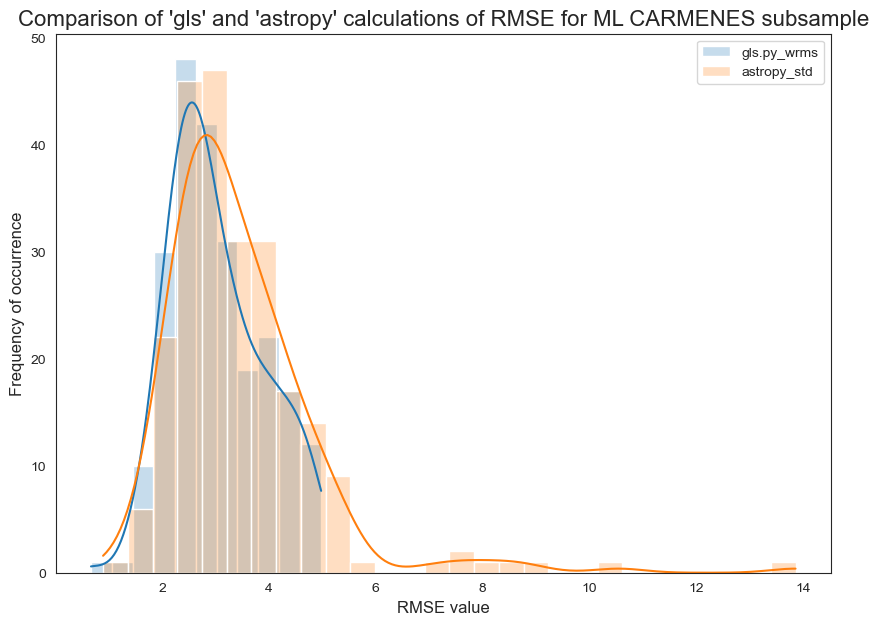

In [763]:
#d_labels = ['wrms_RV', 'astropy_std', 'sklearn_RMSE', 'sklearn_weigthed_RMSE']
d_labels = ['gls.py_wrms', 'astropy_std']
fig_title = "Comparison of 'gls' and 'astropy' calculations of RMSE for ML CARMENES subsample"
multi_compare_dist(results, d_labels=d_labels,
                   varname='RMSE value', fig_title=fig_title,
                   fig_filename=IMG_FOLDER + "ML_00_01_RMS_Distributions_gls_astropy.jpg",
                   kde=True, hist_fill=True)


### Save the list of compliant and non-compliant stars

In [764]:
c_stars = lt5['Karmn'].to_list()
print(c_stars)

['J23505-095', 'J23492+024', 'J23431+365', 'J23419+441', 'J23381-162', 'J23351-023', 'J23340+001', 'J23216+172', 'J22565+165', 'J22559+178', 'J22503-070', 'J22330+093', 'J22057+656', 'J22021+014', 'J22020-194', 'J21466-001', 'J21466+668', 'J21463+382', 'J21348+515', 'J21019-063', 'J20567-104', 'J20556-140S', 'J20533+621', 'J20525-169', 'J20405+154', 'J20336+617', 'J20305+654', 'J20260+585', 'J19251+283', 'J19216+208', 'J19169+051N', 'J19098+176', 'J19084+322', 'J19072+208', 'J19070+208', 'J18480-145', 'J18427+596S', 'J18427+596N', 'J18419+318', 'J18363+136', 'J18353+457', 'J18346+401', 'J18319+406', 'J18224+620', 'J18221+063', 'J18198-019', 'J18180+387E', 'J18165+048', 'J18051-030', 'J18027+375', 'J17578+465', 'J17578+046', 'J17542+073', 'J17378+185', 'J17355+616', 'J17303+055', 'J17198+417', 'J17166+080', 'J17115+384', 'J17071+215', 'J17052-050', 'J16554-083N', 'J16462+164', 'J16327+126', 'J16303-126', 'J16254+543', 'J16167+672N', 'J16092+093', 'J16028+205', 'J15598-082', 'J15583+354'

In [765]:
pickle.dump(c_stars, open(C_STARLIST_FILE, "wb"))

In [766]:
nc_stars = gt5['Karmn'].to_list()
print(nc_stars)

['J23245+578', 'J22114+409', 'J21474+627', 'J21164+025', 'J19242+755', 'J18580+059', 'J18075-159', 'J17033+514', 'J16581+257', 'J14310-122', 'J13582+125', 'J13283-023W', 'J13119+658', 'J13102+477', 'J11302+076', 'J05314-036', 'J04376+528', 'J04219+213', 'J03090+100', 'J01550+379', 'J01026+623']


In [767]:
pickle.dump(nc_stars, open(NC_STARLIST_FILE, "wb"))

## Analyze RMS of the S4 sample RV curves

In [768]:
results_s4 = s4[['ID', 'Pulsating', 'S4_file']].copy()
results_s4.head()

,ID,Pulsating,S4_file
0,Star-00000,True,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
1,Star-00001,True,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
2,Star-00002,False,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
3,Star-00003,False,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
4,Star-00004,True,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...


In [769]:
results_s4.insert(loc=2, column='wrms_RV', value=np.nan)
results_s4.head()

,ID,Pulsating,wrms_RV,S4_file
0,Star-00000,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
1,Star-00001,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
2,Star-00002,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
3,Star-00003,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
4,Star-00004,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...


In [770]:
results_s4[['astropy_std', 'sklearn_RMSE', 'sklearn_weigthed_RMSE']] = np.nan
results_s4.head()

,ID,Pulsating,wrms_RV,S4_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE
0,Star-00000,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,NaN,NaN,NaN
1,Star-00001,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,NaN,NaN,NaN
2,Star-00002,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,NaN,NaN,NaN
3,Star-00003,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,NaN,NaN,NaN
4,Star-00004,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,NaN,NaN,NaN


### Populate the RMSE values (S4 sample)

In [771]:
results_s4

,ID,Pulsating,wrms_RV,S4_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE
0,Star-00000,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,NaN,NaN,NaN
1,Star-00001,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,NaN,NaN,NaN
2,Star-00002,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,NaN,NaN,NaN
3,Star-00003,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,NaN,NaN,NaN
4,Star-00004,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,NaN,NaN,NaN
...,...,...,...,...,...,...,...
995,Star-00995,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,NaN,NaN,NaN
996,Star-00996,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,NaN,NaN,NaN
997,Star-00997,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,NaN,NaN,NaN
998,Star-00998,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,NaN,NaN,NaN


In [772]:
results_s4['astropy_std'] = results_s4['S4_file'].map(lambda x: calculate_std_astropy(x))
results_s4['sklearn_RMSE'] = results_s4['S4_file'].map(lambda x: calculate_rmse_sk(x))
results_s4['sklearn_weigthed_RMSE'] = results_s4['S4_file'].map(lambda x: calculate_weighted_rmse_sk(x))
results_s4

,ID,Pulsating,wrms_RV,S4_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE
0,Star-00000,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.644180,1.685500,1.499767
1,Star-00001,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.858990,1.859166,1.652651
2,Star-00002,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.658910,1.659031,1.465087
3,Star-00003,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.533950,1.533962,1.257433
4,Star-00004,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.740790,1.741136,1.639499
...,...,...,...,...,...,...,...
995,Star-00995,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,2.554470,2.926033,2.950035
996,Star-00996,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,0.984859,1.042441,1.062219
997,Star-00997,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.680170,1.680323,1.402286
998,Star-00998,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,8.184760,8.272370,7.467557


In [773]:
results_s4.rename(columns={'wrms_RV': 'gls.py_wrms'}, inplace=True)
results_s4

,ID,Pulsating,gls.py_wrms,S4_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE
0,Star-00000,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.644180,1.685500,1.499767
1,Star-00001,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.858990,1.859166,1.652651
2,Star-00002,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.658910,1.659031,1.465087
3,Star-00003,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.533950,1.533962,1.257433
4,Star-00004,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.740790,1.741136,1.639499
...,...,...,...,...,...,...,...
995,Star-00995,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,2.554470,2.926033,2.950035
996,Star-00996,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,0.984859,1.042441,1.062219
997,Star-00997,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.680170,1.680323,1.402286
998,Star-00998,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,8.184760,8.272370,7.467557


In [774]:
len(results_s4)

1000

In [775]:
results_s4['Compliant'] = (results_s4['astropy_std'] <= 5.0) & \
    (results_s4['sklearn_RMSE'] <= 5.0) & (results_s4['sklearn_weigthed_RMSE'] <= 5.0)
results_s4

,ID,Pulsating,gls.py_wrms,S4_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE,Compliant
0,Star-00000,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.644180,1.685500,1.499767,True
1,Star-00001,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.858990,1.859166,1.652651,True
2,Star-00002,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.658910,1.659031,1.465087,True
3,Star-00003,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.533950,1.533962,1.257433,True
4,Star-00004,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.740790,1.741136,1.639499,True
...,...,...,...,...,...,...,...,...
995,Star-00995,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,2.554470,2.926033,2.950035,True
996,Star-00996,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,0.984859,1.042441,1.062219,True
997,Star-00997,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.680170,1.680323,1.402286,True
998,Star-00998,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,8.184760,8.272370,7.467557,False


#### Save the full results

In [776]:
results_s4.to_csv(S4_FULL_RESULTS_FILE, sep=',', decimal='.', index=False)

### Check results (S4 sample)

In [777]:
res_stats_s4 = results_s4.describe()
res_stats_s4

,gls.py_wrms,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE
count,0.0,1000.000000,1000.000000,1000.000000
mean,NaN,1.899819,1.952874,1.460970
std,NaN,1.750524,1.860128,0.433855
min,NaN,0.458396,0.537153,0.509878
25%,NaN,1.373985,1.408963,1.238702
50%,NaN,1.635515,1.674780,1.404879
75%,NaN,1.990382,2.060464,1.631987
max,NaN,38.857700,43.351884,7.467557


#### Save results

In [778]:
res_stats_s4.to_csv(S4_RMS_DESCRIBE_RESULTS, sep=',', decimal='.')

In [779]:
len(results_s4[results_s4['astropy_std'] > 5.0])

14

In [780]:
len(results_s4[results_s4['sklearn_RMSE'] > 5.0])

15

In [781]:
len(results_s4[results_s4['sklearn_weigthed_RMSE'] > 5.0])

3

### Comparative distributions of values (S4 sample)

In [782]:
results_s4.columns

Index(['ID', 'Pulsating', 'gls.py_wrms', 'S4_file', 'astropy_std',
       'sklearn_RMSE', 'sklearn_weigthed_RMSE', 'Compliant'],
      dtype='object')

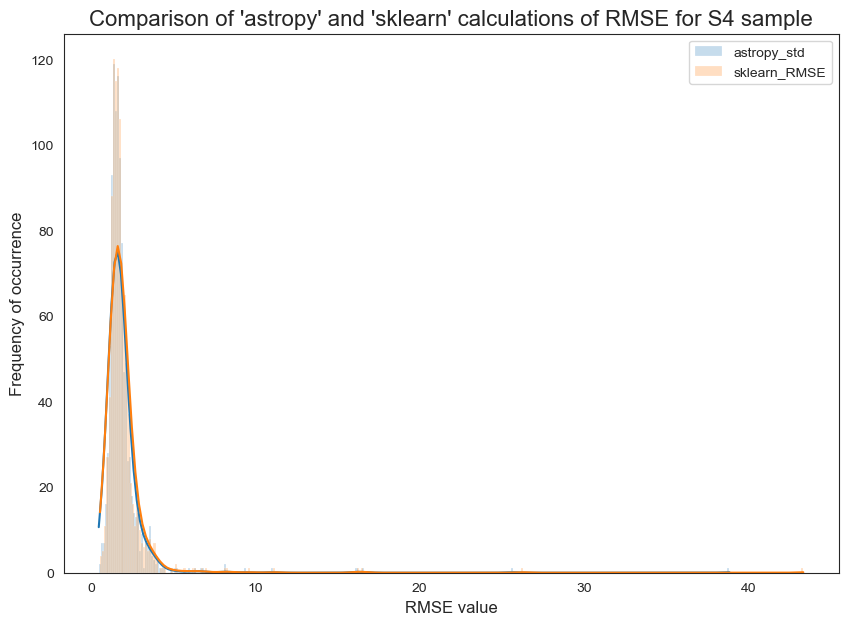

In [783]:
#d_labels = ['wrms_RV', 'astropy_std', 'sklearn_RMSE', 'sklearn_weigthed_RMSE']
d_labels = ['astropy_std', 'sklearn_RMSE']
fig_title = "Comparison of 'astropy' and 'sklearn' calculations of RMSE for S4 sample"
multi_compare_dist(results_s4, d_labels=d_labels,
                   varname='RMSE value', fig_title=fig_title,
                   fig_filename=IMG_FOLDER + "ML_00_02_S4_RMS_Distributions_astropy_sklearn.jpg",
                   kde=True, hist_fill=True)


## Analyze RMS of the ALTERNATIVE S4 sample RV curves

In [784]:
results_alt_s4 = alt_s4[['ID', 'Pulsating', 'S4_ALT_file']].copy()
results_alt_s4.head()

,ID,Pulsating,S4_ALT_file
0,ALT_Star-00000,True,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...
1,ALT_Star-00001,False,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...
2,ALT_Star-00002,True,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...
3,ALT_Star-00003,False,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...
4,ALT_Star-00004,True,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...


In [785]:
results_alt_s4.insert(loc=2, column='wrms_RV', value=np.nan)
results_alt_s4.head()

,ID,Pulsating,wrms_RV,S4_ALT_file
0,ALT_Star-00000,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...
1,ALT_Star-00001,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...
2,ALT_Star-00002,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...
3,ALT_Star-00003,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...
4,ALT_Star-00004,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...


In [786]:
results_alt_s4[['astropy_std', 'sklearn_RMSE', 'sklearn_weigthed_RMSE']] = np.nan
results_alt_s4.head()

,ID,Pulsating,wrms_RV,S4_ALT_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE
0,ALT_Star-00000,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,NaN,NaN,NaN
1,ALT_Star-00001,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,NaN,NaN,NaN
2,ALT_Star-00002,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,NaN,NaN,NaN
3,ALT_Star-00003,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,NaN,NaN,NaN
4,ALT_Star-00004,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,NaN,NaN,NaN


### Populate the RMSE values (ALTERNATIVE S4 sample)

In [787]:
results_alt_s4

,ID,Pulsating,wrms_RV,S4_ALT_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE
0,ALT_Star-00000,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,NaN,NaN,NaN
1,ALT_Star-00001,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,NaN,NaN,NaN
2,ALT_Star-00002,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,NaN,NaN,NaN
3,ALT_Star-00003,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,NaN,NaN,NaN
4,ALT_Star-00004,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,NaN,NaN,NaN
...,...,...,...,...,...,...,...
9315,ALT_Star-09315,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,NaN,NaN,NaN
9316,ALT_Star-09316,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,NaN,NaN,NaN
9317,ALT_Star-09317,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,NaN,NaN,NaN
9318,ALT_Star-09318,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,NaN,NaN,NaN


In [788]:
results_alt_s4['astropy_std'] = results_alt_s4['S4_ALT_file'].map(lambda x: calculate_std_astropy(x))
results_alt_s4['sklearn_RMSE'] = results_alt_s4['S4_ALT_file'].map(lambda x: calculate_rmse_sk(x))
results_alt_s4['sklearn_weigthed_RMSE'] = results_alt_s4['S4_ALT_file'].map(lambda x: calculate_weighted_rmse_sk(x))
results_alt_s4

,ID,Pulsating,wrms_RV,S4_ALT_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE
0,ALT_Star-00000,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.82432,1.937276,1.673708
1,ALT_Star-00001,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.75327,1.788531,1.537871
2,ALT_Star-00002,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.93014,1.931157,1.605890
3,ALT_Star-00003,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.49640,1.543934,1.516478
4,ALT_Star-00004,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.76981,1.777331,1.470104
...,...,...,...,...,...,...,...
9315,ALT_Star-09315,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,2.23715,2.276663,1.579836
9316,ALT_Star-09316,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,2.15516,2.164328,1.553172
9317,ALT_Star-09317,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.47854,1.528966,1.478189
9318,ALT_Star-09318,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,2.10630,2.106312,1.740855


In [789]:
results_alt_s4.rename(columns={'wrms_RV': 'gls.py_wrms'}, inplace=True)
results_alt_s4

,ID,Pulsating,gls.py_wrms,S4_ALT_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE
0,ALT_Star-00000,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.82432,1.937276,1.673708
1,ALT_Star-00001,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.75327,1.788531,1.537871
2,ALT_Star-00002,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.93014,1.931157,1.605890
3,ALT_Star-00003,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.49640,1.543934,1.516478
4,ALT_Star-00004,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.76981,1.777331,1.470104
...,...,...,...,...,...,...,...
9315,ALT_Star-09315,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,2.23715,2.276663,1.579836
9316,ALT_Star-09316,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,2.15516,2.164328,1.553172
9317,ALT_Star-09317,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.47854,1.528966,1.478189
9318,ALT_Star-09318,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,2.10630,2.106312,1.740855


In [790]:
len(results_alt_s4)

9320

In [791]:
results_alt_s4['Compliant'] = (results_alt_s4['astropy_std'] <= 5.0) & \
    (results_alt_s4['sklearn_RMSE'] <= 5.0) & (results_alt_s4['sklearn_weigthed_RMSE'] <= 5.0)
results_alt_s4

,ID,Pulsating,gls.py_wrms,S4_ALT_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE,Compliant
0,ALT_Star-00000,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.82432,1.937276,1.673708,True
1,ALT_Star-00001,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.75327,1.788531,1.537871,True
2,ALT_Star-00002,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.93014,1.931157,1.605890,True
3,ALT_Star-00003,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.49640,1.543934,1.516478,True
4,ALT_Star-00004,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.76981,1.777331,1.470104,True
...,...,...,...,...,...,...,...,...
9315,ALT_Star-09315,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,2.23715,2.276663,1.579836,True
9316,ALT_Star-09316,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,2.15516,2.164328,1.553172,True
9317,ALT_Star-09317,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.47854,1.528966,1.478189,True
9318,ALT_Star-09318,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,2.10630,2.106312,1.740855,True


#### Save the full results

In [792]:
results_alt_s4.to_csv(ALT_S4_FULL_RESULTS_FILE, sep=',', decimal='.', index=False)

### Check results (ALTERNATIVE S4 sample)

In [793]:
res_stats_alt_s4 = results_alt_s4.describe()
res_stats_alt_s4

,gls.py_wrms,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE
count,0.0,9320.000000,9320.000000,9320.000000
mean,NaN,1.801290,1.859762,1.510568
std,NaN,0.958531,1.057897,0.543622
min,NaN,0.152868,0.370473,0.297408
25%,NaN,1.383382,1.420208,1.263603
50%,NaN,1.647480,1.679666,1.446773
75%,NaN,1.975057,2.016109,1.673231
max,NaN,23.451800,25.349926,14.468372


#### Save results

In [794]:
res_stats_alt_s4.to_csv(ALT_S4_RMS_DESCRIBE_RESULTS, sep=',', decimal='.')

In [795]:
len(results_alt_s4[results_alt_s4['astropy_std'] > 5.0])

94

In [796]:
len(results_alt_s4[results_alt_s4['sklearn_RMSE'] > 5.0])

107

In [797]:
len(results_alt_s4[results_alt_s4['sklearn_weigthed_RMSE'] > 5.0])

27

### Comparative distributions of values

In [798]:
results_alt_s4.columns

Index(['ID', 'Pulsating', 'gls.py_wrms', 'S4_ALT_file', 'astropy_std',
       'sklearn_RMSE', 'sklearn_weigthed_RMSE', 'Compliant'],
      dtype='object')

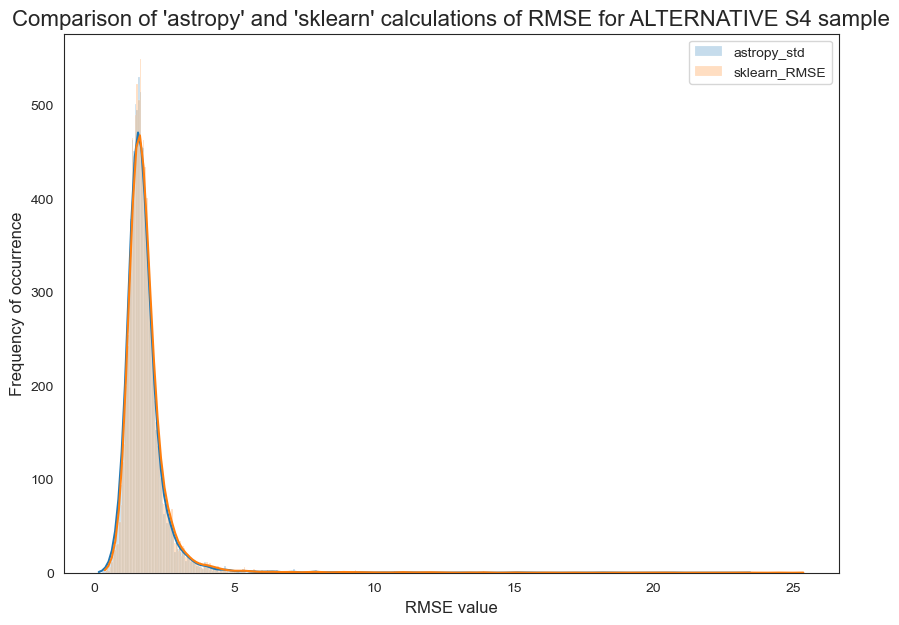

In [799]:
#d_labels = ['wrms_RV', 'astropy_std', 'sklearn_RMSE', 'sklearn_weigthed_RMSE']
d_labels = ['astropy_std', 'sklearn_RMSE']
fig_title = "Comparison of 'astropy' and 'sklearn' calculations of RMSE for ALTERNATIVE S4 sample"
multi_compare_dist(results_alt_s4, d_labels=d_labels,
                   varname='RMSE value', fig_title=fig_title,
                   fig_filename=IMG_FOLDER + "ML_00_03_ALT_S4_RMS_Distributions_astropy_sklearn.jpg",
                   kde=True, hist_fill=True)


## Plot the results for reference

### Example of compliant RV curve

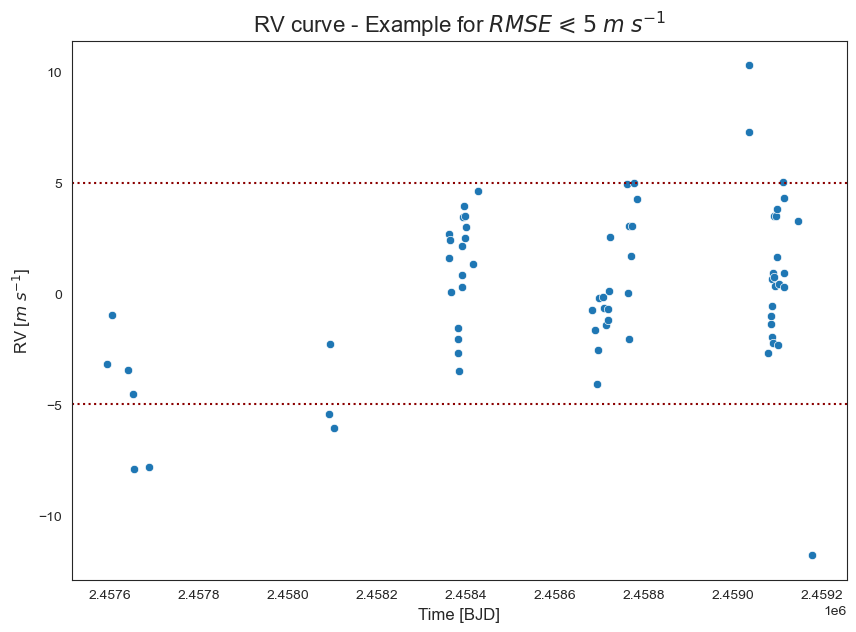

In [800]:
rv_file = lt5.loc[0, 'rv_file']
rv = pd.read_csv(rv_file, sep=' ', decimal='.', names=['BJD', 'RV', 'RV_error'])
draw_curves(times=[rv['BJD']], values=[rv['RV']],
            value_label="RV [$m\;s^{-1}$]",
            ymarks = [-5.0, 5.0],
            title="RV curve - Example for $RMSE\;\eqslantless\;5\;m\;s^{-1}$", fig_filename=None)

### Example of non-compliant RV curve

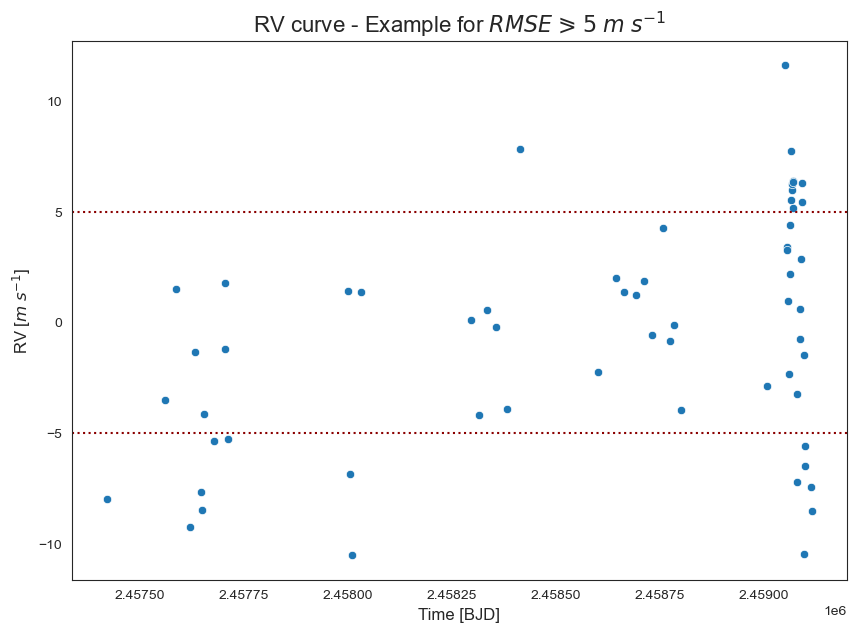

In [801]:
rv_file = gt5.loc[0, 'rv_file']
rv = pd.read_csv(rv_file, sep=' ', decimal='.', names=['BJD', 'RV', 'RV_error'])
draw_curves(times=[rv['BJD']], values=[rv['RV']],
            value_label="RV [$m\;s^{-1}$]",
            ymarks = [-5.0, 5.0],
            title="RV curve - Example for $RMSE\;\eqslantgtr\;5\;m\;s^{-1}$", fig_filename=None)

### Save all figures to file

#### ML subsample

In [802]:
results.columns

Index(['Karmn', 'gls.py_wrms', 'rv_file', 'astropy_std', 'sklearn_RMSE',
       'sklearn_weigthed_RMSE', 'Compliant'],
      dtype='object')

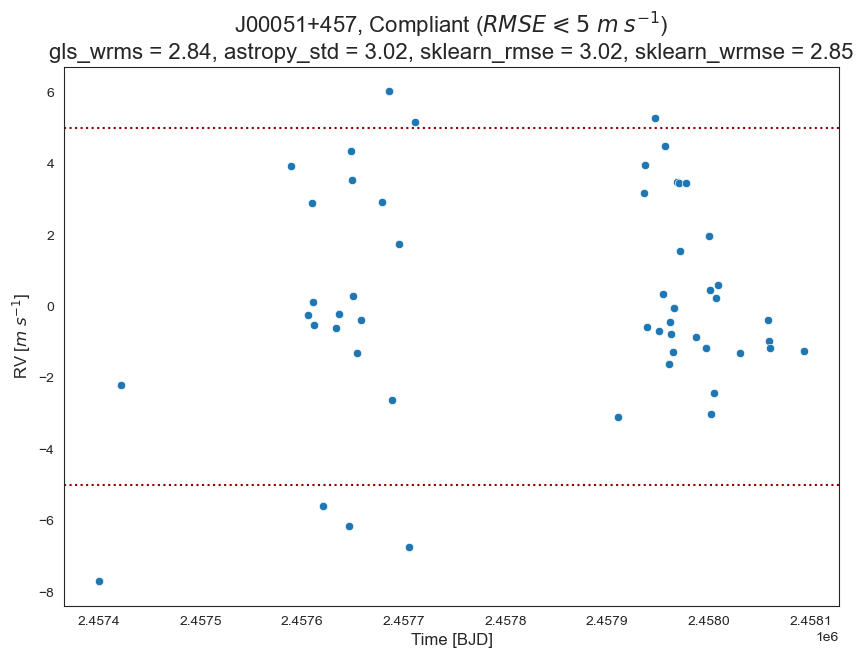

In [803]:
for i in range(0,len(results)):
    clear_output(wait=True)
    rv_file = results.loc[i, 'rv_file']
    rv = pd.read_csv(rv_file, sep=' ', decimal='.', names=['BJD', 'RV', 'RV_error'])
    star_id = results.loc[i, 'Karmn']
    
    if np.abs(rv['RV']).max() >= 5.0:
        ymarks = [-5.0, 5.0]
    else:
        ymarks = []
    
    if results.loc[i, 'Compliant'] == True:
        title = star_id + ", Compliant ($RMSE\;\eqslantless\;5\;m\;s^{-1}$)"
        fig_filename = IMG_FOLDER_LTE5 + star_id + "RV_curve.jpg"
    else:
        title = star_id + ", Non-compliant ($RMSE\;\eqslantgtr\;5\;m\;s^{-1}$)"
        fig_filename = IMG_FOLDER_GT5 + star_id + "RV_curve.jpg"
    
    title += "\ngls_wrms = %.2f, astropy_std = %.2f, sklearn_rmse = %.2f, sklearn_wrmse = %.2f" \
        %(results.loc[i, 'gls.py_wrms'], results.loc[i, 'astropy_std'],
          results.loc[i, 'sklearn_RMSE'], results.loc[i, 'sklearn_weigthed_RMSE'])
    
    draw_curves(times=[rv['BJD']], values=[rv['RV']],
                value_label="RV [$m\;s^{-1}$]",
                ymarks=ymarks,
                title=title, fig_filename=fig_filename)
    plt.show();

#### S4 sample

In [804]:
results_s4.columns

Index(['ID', 'Pulsating', 'gls.py_wrms', 'S4_file', 'astropy_std',
       'sklearn_RMSE', 'sklearn_weigthed_RMSE', 'Compliant'],
      dtype='object')

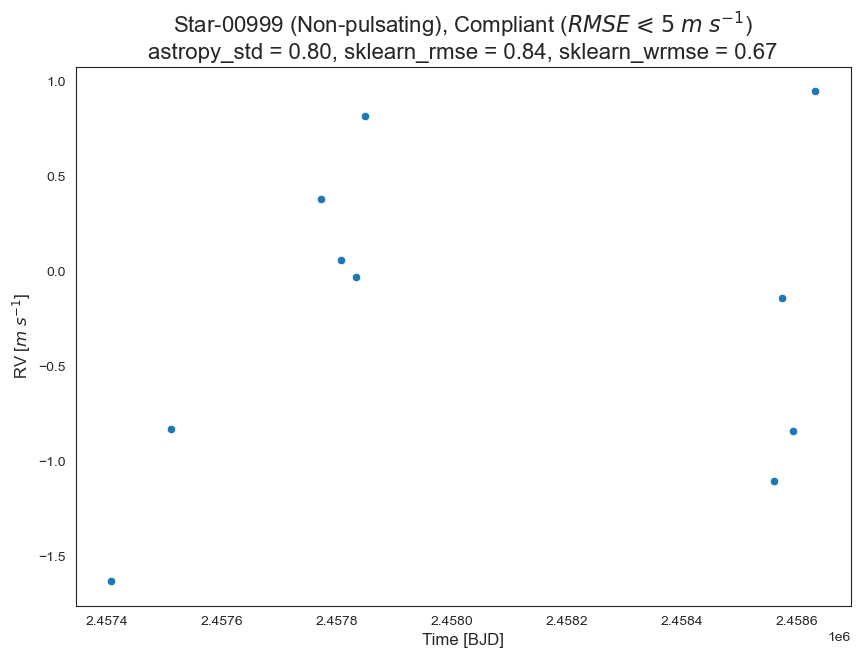

In [805]:
for i in range(0,len(results_s4)):
    clear_output(wait=True)
    rv_file = results_s4.loc[i, 'S4_file']
    rv = pd.read_csv(rv_file, sep=' ', decimal='.', names=['BJD', 'RV', 'RV_error'])
    star_id = results_s4.loc[i, 'ID']
    star_class = "Pulsating" if results_s4.loc[i, 'Pulsating'] == True else "Non-pulsating"
    if np.abs(rv['RV']).max() >= 5.0:
        ymarks = [-5.0, 5.0]
    else:
        ymarks = []
    
    if results_s4.loc[i, 'Compliant'] == True:
        title = star_id + " (" + star_class + ")" + ", Compliant ($RMSE\;\eqslantless\;5\;m\;s^{-1}$)"
        fig_filename = IMG_FOLDER_S4_C + star_id + "RV_curve.jpg"
    else:
        title = star_id +  " (" + star_class + ")" + ", Non-compliant ($RMSE\;\eqslantgtr\;5\;m\;s^{-1}$)"
        fig_filename = IMG_FOLDER_S4_NC + star_id + "RV_curve.jpg"
    
    title += "\nastropy_std = %.2f, sklearn_rmse = %.2f, sklearn_wrmse = %.2f" \
        %(results_s4.loc[i, 'astropy_std'],
          results_s4.loc[i, 'sklearn_RMSE'], results_s4.loc[i, 'sklearn_weigthed_RMSE'])
    
    draw_curves(times=[rv['BJD']], values=[rv['RV']],
                value_label="RV [$m\;s^{-1}$]",
                ymarks=ymarks,
                title=title, fig_filename=fig_filename)
    plt.show();

#### ALTERNATIVE S4 sample

In [806]:
results_alt_s4.columns

Index(['ID', 'Pulsating', 'gls.py_wrms', 'S4_ALT_file', 'astropy_std',
       'sklearn_RMSE', 'sklearn_weigthed_RMSE', 'Compliant'],
      dtype='object')

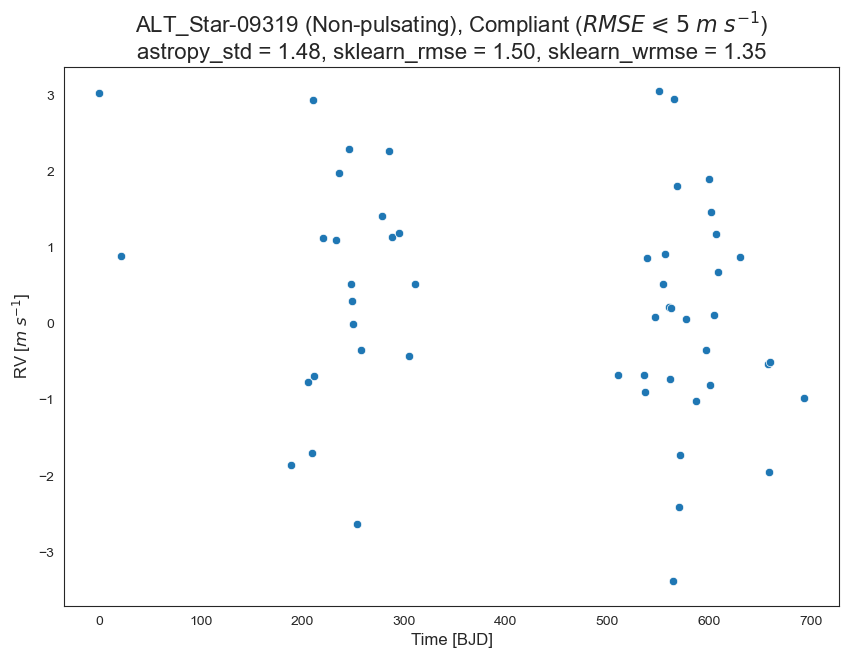

In [807]:
for i in range(0,len(results_alt_s4)):
    clear_output(wait=True)
    rv_file = results_alt_s4.loc[i, 'S4_ALT_file']
    rv = pd.read_csv(rv_file, sep=' ', decimal='.', names=['BJD', 'RV', 'RV_error'])
    star_id = results_alt_s4.loc[i, 'ID']
    star_class = "Pulsating" if results_alt_s4.loc[i, 'Pulsating'] == True else "Non-pulsating"
    if np.abs(rv['RV']).max() >= 5.0:
        ymarks = [-5.0, 5.0]
    else:
        ymarks = []
    
    if results_alt_s4.loc[i, 'Compliant'] == True:
        title = star_id + " (" + star_class + ")" + ", Compliant ($RMSE\;\eqslantless\;5\;m\;s^{-1}$)"
        fig_filename = IMG_FOLDER_ALT_S4_C + star_id + "RV_curve.jpg"
    else:
        title = star_id +  " (" + star_class + ")" + ", Non-compliant ($RMSE\;\eqslantgtr\;5\;m\;s^{-1}$)"
        fig_filename = IMG_FOLDER_ALT_S4_NC + star_id + "RV_curve.jpg"
    
    title += "\nastropy_std = %.2f, sklearn_rmse = %.2f, sklearn_wrmse = %.2f" \
        %(results_alt_s4.loc[i, 'astropy_std'],
          results_alt_s4.loc[i, 'sklearn_RMSE'], results_alt_s4.loc[i, 'sklearn_weigthed_RMSE'])
    
    draw_curves(times=[rv['BJD']], values=[rv['RV']],
                value_label="RV [$m\;s^{-1}$]",
                ymarks=ymarks,
                title=title, fig_filename=fig_filename)
    plt.show();

## All results combined in a single file

In [808]:
backup_results = results.copy()

In [809]:
# TO RECOVER ORIGINAL RESULTS DATAFRAME:
results = backup_results.copy()

In [810]:
try:
    results.insert(loc=0, column='Sample', value="CARMENES ML subsample")
except:
    pass
results.head()

,Sample,Karmn,gls.py_wrms,rv_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE,Compliant
0,CARMENES ML subsample,J23505-095,3.362607,../data/CARM_VIS_RVs/J23505-095.avc.dat,3.58753,3.592743,3.303345,True
1,CARMENES ML subsample,J23492+024,2.183867,../data/CARM_VIS_RVs/J23492+024.avc.dat,2.50473,2.505042,2.148606,True
2,CARMENES ML subsample,J23431+365,2.795865,../data/CARM_VIS_RVs/J23431+365.avc.dat,2.63638,2.636442,2.745168,True
3,CARMENES ML subsample,J23419+441,2.532704,../data/CARM_VIS_RVs/J23419+441.avc.dat,2.60045,2.600656,2.539899,True
4,CARMENES ML subsample,J23381-162,2.405056,../data/CARM_VIS_RVs/J23381-162.avc.dat,3.72518,3.726117,2.113373,True


In [811]:
try:
    results.insert(loc=2, column='Pulsating', value=np.nan)
except:
    pass
results.head()

,Sample,Karmn,Pulsating,gls.py_wrms,rv_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE,Compliant
0,CARMENES ML subsample,J23505-095,NaN,3.362607,../data/CARM_VIS_RVs/J23505-095.avc.dat,3.58753,3.592743,3.303345,True
1,CARMENES ML subsample,J23492+024,NaN,2.183867,../data/CARM_VIS_RVs/J23492+024.avc.dat,2.50473,2.505042,2.148606,True
2,CARMENES ML subsample,J23431+365,NaN,2.795865,../data/CARM_VIS_RVs/J23431+365.avc.dat,2.63638,2.636442,2.745168,True
3,CARMENES ML subsample,J23419+441,NaN,2.532704,../data/CARM_VIS_RVs/J23419+441.avc.dat,2.60045,2.600656,2.539899,True
4,CARMENES ML subsample,J23381-162,NaN,2.405056,../data/CARM_VIS_RVs/J23381-162.avc.dat,3.72518,3.726117,2.113373,True


In [812]:
try:
    results.rename(columns={'Karmn': 'ID'}, inplace=True)
except:
    pass
results.head()

,Sample,ID,Pulsating,gls.py_wrms,rv_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE,Compliant
0,CARMENES ML subsample,J23505-095,NaN,3.362607,../data/CARM_VIS_RVs/J23505-095.avc.dat,3.58753,3.592743,3.303345,True
1,CARMENES ML subsample,J23492+024,NaN,2.183867,../data/CARM_VIS_RVs/J23492+024.avc.dat,2.50473,2.505042,2.148606,True
2,CARMENES ML subsample,J23431+365,NaN,2.795865,../data/CARM_VIS_RVs/J23431+365.avc.dat,2.63638,2.636442,2.745168,True
3,CARMENES ML subsample,J23419+441,NaN,2.532704,../data/CARM_VIS_RVs/J23419+441.avc.dat,2.60045,2.600656,2.539899,True
4,CARMENES ML subsample,J23381-162,NaN,2.405056,../data/CARM_VIS_RVs/J23381-162.avc.dat,3.72518,3.726117,2.113373,True


In [813]:
try:
    results_s4.insert(loc=0, column='Sample', value="S4 sample")
except:
    pass
results_s4.head()

,Sample,ID,Pulsating,gls.py_wrms,S4_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE,Compliant
0,S4 sample,Star-00000,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.64418,1.685500,1.499767,True
1,S4 sample,Star-00001,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.85899,1.859166,1.652651,True
2,S4 sample,Star-00002,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.65891,1.659031,1.465087,True
3,S4 sample,Star-00003,False,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.53395,1.533962,1.257433,True
4,S4 sample,Star-00004,True,NaN,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,1.74079,1.741136,1.639499,True


In [814]:
try:
    results_alt_s4.insert(loc=0, column='Sample', value="ALT_S4 sample")
except:
    pass
results_alt_s4.head()

,Sample,ID,Pulsating,gls.py_wrms,S4_ALT_file,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE,Compliant
0,ALT_S4 sample,ALT_Star-00000,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.82432,1.937276,1.673708,True
1,ALT_S4 sample,ALT_Star-00001,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.75327,1.788531,1.537871,True
2,ALT_S4 sample,ALT_Star-00002,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.93014,1.931157,1.605890,True
3,ALT_S4 sample,ALT_Star-00003,False,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.49640,1.543934,1.516478,True
4,ALT_S4 sample,ALT_Star-00004,True,NaN,../data/SYNTH_RV_SAMPLES/S4_ALTERNATIVE_ts_fil...,1.76981,1.777331,1.470104,True


Join all the data together.

In [815]:
global_results = pd.concat([results[['Sample', 'ID', 'Pulsating', 'gls.py_wrms', 'astropy_std',
                                     'sklearn_RMSE', 'sklearn_weigthed_RMSE', 'Compliant']],
                            results_s4[['Sample', 'ID', 'Pulsating', 'gls.py_wrms', 'astropy_std',
                                        'sklearn_RMSE', 'sklearn_weigthed_RMSE', 'Compliant']],
                            results_alt_s4[['Sample', 'ID', 'Pulsating', 'gls.py_wrms', 'astropy_std',
                                            'sklearn_RMSE', 'sklearn_weigthed_RMSE', 'Compliant']]],
                           ignore_index=True)
global_results

C:\Users\ciroe\AppData\Local\Temp\ipykernel_6452\2803532128.py:1: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  global_results = pd.concat([results[['Sample', 'ID', 'Pulsating', 'gls.py_wrms', 'astropy_std',


,Sample,ID,Pulsating,gls.py_wrms,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE,Compliant
0,CARMENES ML subsample,J23505-095,NaN,3.362607,3.58753,3.592743,3.303345,True
1,CARMENES ML subsample,J23492+024,NaN,2.183867,2.50473,2.505042,2.148606,True
2,CARMENES ML subsample,J23431+365,NaN,2.795865,2.63638,2.636442,2.745168,True
3,CARMENES ML subsample,J23419+441,NaN,2.532704,2.60045,2.600656,2.539899,True
4,CARMENES ML subsample,J23381-162,NaN,2.405056,3.72518,3.726117,2.113373,True
...,...,...,...,...,...,...,...,...
10548,ALT_S4 sample,ALT_Star-09315,0.0,NaN,2.23715,2.276663,1.579836,True
10549,ALT_S4 sample,ALT_Star-09316,1.0,NaN,2.15516,2.164328,1.553172,True
10550,ALT_S4 sample,ALT_Star-09317,0.0,NaN,1.47854,1.528966,1.478189,True
10551,ALT_S4 sample,ALT_Star-09318,1.0,NaN,2.10630,2.106312,1.740855,True


In [816]:
global_results.loc[global_results['Pulsating'].isna(), 'Pulsating'] = 'Unknown'
global_results.loc[global_results['Pulsating'] == 0, 'Pulsating'] = 'Non-pulsating'
global_results.loc[global_results['Pulsating'] == 1, 'Pulsating'] = 'Pulsating'

In [817]:
global_results.rename(columns={'Pulsating': 'Star type'}, inplace=True)
global_results

,Sample,ID,Star type,gls.py_wrms,astropy_std,sklearn_RMSE,sklearn_weigthed_RMSE,Compliant
0,CARMENES ML subsample,J23505-095,Unknown,3.362607,3.58753,3.592743,3.303345,True
1,CARMENES ML subsample,J23492+024,Unknown,2.183867,2.50473,2.505042,2.148606,True
2,CARMENES ML subsample,J23431+365,Unknown,2.795865,2.63638,2.636442,2.745168,True
3,CARMENES ML subsample,J23419+441,Unknown,2.532704,2.60045,2.600656,2.539899,True
4,CARMENES ML subsample,J23381-162,Unknown,2.405056,3.72518,3.726117,2.113373,True
...,...,...,...,...,...,...,...,...
10548,ALT_S4 sample,ALT_Star-09315,Non-pulsating,NaN,2.23715,2.276663,1.579836,True
10549,ALT_S4 sample,ALT_Star-09316,Pulsating,NaN,2.15516,2.164328,1.553172,True
10550,ALT_S4 sample,ALT_Star-09317,Non-pulsating,NaN,1.47854,1.528966,1.478189,True
10551,ALT_S4 sample,ALT_Star-09318,Pulsating,NaN,2.10630,2.106312,1.740855,True


### Save global file

In [818]:
global_results.to_csv(GLOBAL_FULL_RESULTS, sep=',', decimal='.', index=False)

## Global comparison of RMSE values (ML / S4 / ALT S4)

### Compliant/Non-compliant

#### Overall

In [819]:
global_results[['ID', 'Sample', 'Compliant']].groupby(by=['Sample', 'Compliant']).count()

ID
Sample                Compliant      
ALT_S4 sample         False       109
                      True       9211
CARMENES ML subsample False        21
                      True        212
S4 sample             False        15
                      True        985

#### By pulsating/non-pulsating

In [820]:
global_results[['ID', 'Sample', 'Star type', 'Compliant']] \
    .groupby(by=['Sample', 'Compliant', 'Star type']).count()

ID
Sample                Compliant Star type          
ALT_S4 sample         False     Non-pulsating    54
                                Pulsating        55
                      True      Non-pulsating  4606
                                Pulsating      4605
CARMENES ML subsample False     Unknown          21
                      True      Unknown         212
S4 sample             False     Non-pulsating    15
                      True      Non-pulsating   881
                                Pulsating       104

**IMPORTANT OBSERVATION:** The numbers are of the same order of magnitude for ML subsample ($\sim9\%$) and S4 / ALT_S4 samples ($\sim1.5\%$ and $\sim1.1\%$).

One interesting (curious) aspect is that in S4 sample, the non-compliant stars are all non-pulsating, while in ALT_S4 sample the non-compliant stars are both pulsating and non-pulsating stars.

### Statistics of  `astropy_std`

#### All three samples

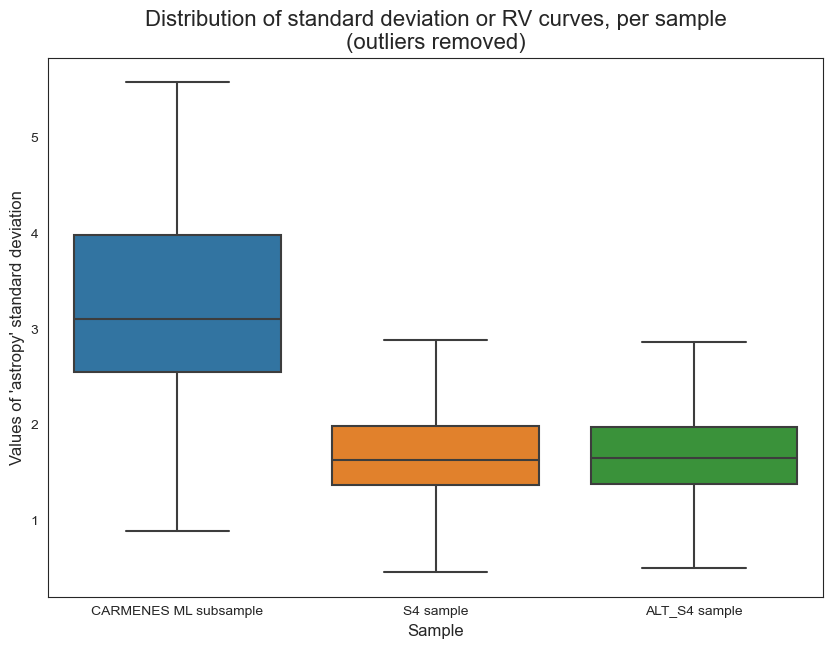

In [821]:
fig_title = "Distribution of standard deviation or RV curves, per sample\n" \
    "(outliers removed)"
fig_filename = IMG_FOLDER + "ML_00_04_astropy_std_Distributions_ML_S4_ALTS4.jpg"

plt.figure(figsize=(10,7))
sns.boxplot(data=global_results, x='Sample', y='astropy_std', sym="")
plt.title(fig_title, fontsize=16)
plt.xlabel("Sample", fontsize=12)
plt.ylabel("Values of 'astropy' standard deviation", fontsize=12)
plt.savefig(fig_filename, format='jpg', bbox_inches='tight');


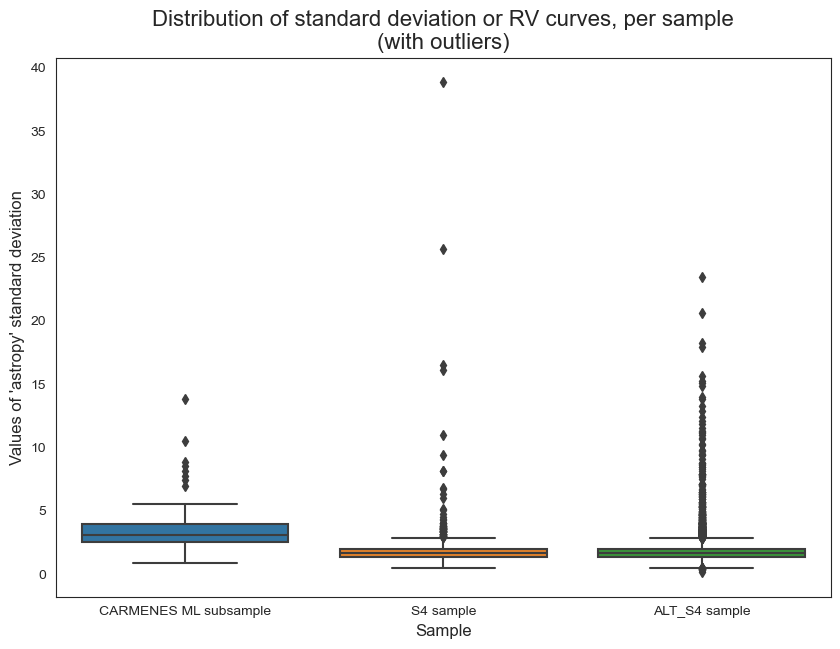

In [822]:
fig_title = "Distribution of standard deviation or RV curves, per sample\n" \
    "(with outliers)"
fig_filename = IMG_FOLDER + "ML_00_05_astropy_std_Distributions_ML_S4_ALTS4_with_outliers.jpg"

plt.figure(figsize=(10,7))
sns.boxplot(data=global_results, x='Sample', y='astropy_std', sym=None)
plt.title(fig_title, fontsize=16)
plt.xlabel("Sample", fontsize=12)
plt.ylabel("Values of 'astropy' standard deviation", fontsize=12)
plt.savefig(fig_filename, format='jpg', bbox_inches='tight');

### Pulsating / non-pulsating

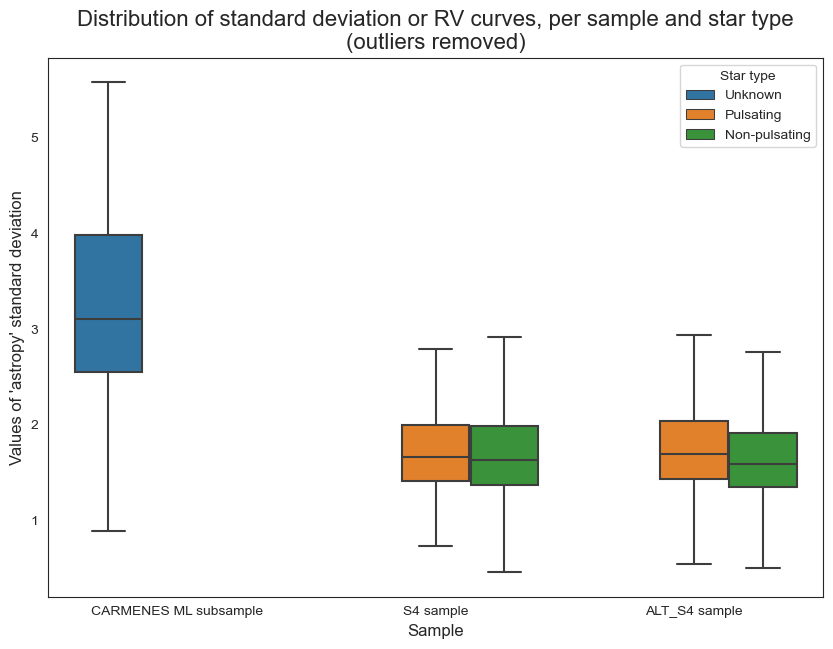

In [823]:
fig_title = "Distribution of standard deviation or RV curves, per sample and star type\n" \
    "(outliers removed)"
fig_filename = IMG_FOLDER + "ML_00_06_astropy_std_Distributions_S4_ALTS4_PNP.jpg"

plt.figure(figsize=(10,7))
sns.boxplot(data=global_results, x='Sample', y='astropy_std', hue='Star type', sym="")
plt.title(fig_title, fontsize=16)
plt.xlabel("Sample", fontsize=12)
plt.ylabel("Values of 'astropy' standard deviation", fontsize=12)
plt.savefig(fig_filename, format='jpg', bbox_inches='tight');


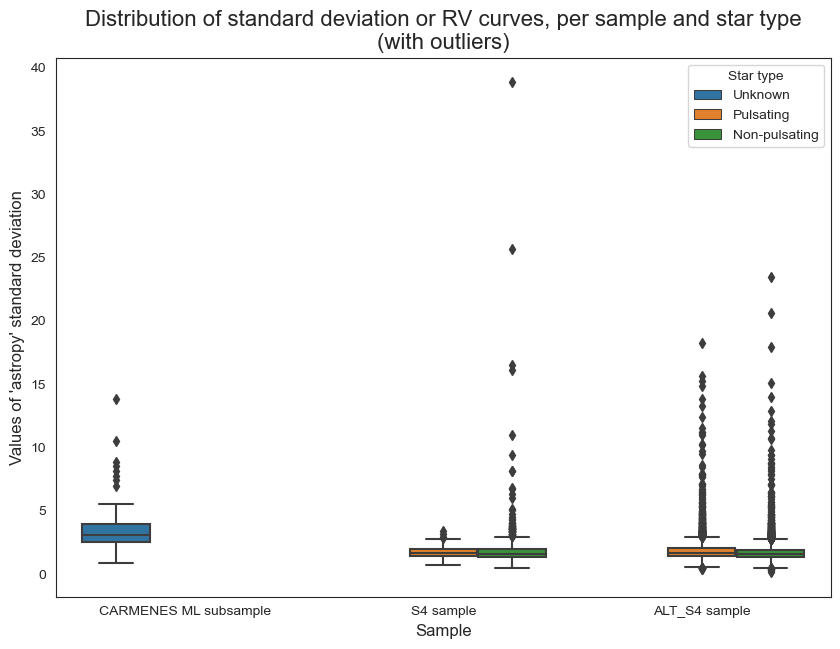

In [824]:
fig_title = "Distribution of standard deviation or RV curves, per sample and star type\n" \
    "(with outliers)"
fig_filename = IMG_FOLDER + "ML_00_07_astropy_std_Distributions_ML_S4_ALTS4_PNP_with_outliers.jpg"

plt.figure(figsize=(10,7))
sns.boxplot(data=global_results, x='Sample', y='astropy_std', hue='Star type', sym=None)
plt.title(fig_title, fontsize=16)
plt.xlabel("Sample", fontsize=12)
plt.ylabel("Values of 'astropy' standard deviation", fontsize=12)
plt.savefig(fig_filename, format='jpg', bbox_inches='tight');

## Summary

**RESULTS:**
- We have detected that $21$ (out of the $233$ pre-selected CARMENES stars) which theoretically have RMSE values which are higher the $5\;m\;s^{-1}$.
- However, the appearence of the stars which are supposedly non-compliant is not that different from some of the compliant stars.
- Also, none of the S4 sample and ALTERNATIVE S4 sample seems to mimic well the ML subsample behaviour in terms of RMS of the RV curve.
- S4 and ALT_S4 samples show, in general, the same distributions. However, the difference in RMS value between the pulsating and non-pulsatign sub-groups is more relevant in the ALT_S4 case that in the S4 case.

**CONCLUSSION:**
- It seems clear that `gls` module does some additional preprocessing of the data before calculating its RMSE value for a given RV curve.
- The number of non-compliant stars are $\sim10\%$ of the $233$ stars. **The recommendation is to go ahead with them**, and just have the list at hand to review the prediction results on that set.
- However, there seems to be something wrong with the S4 / ALT_S4 samples creation, at least with respect to the RMS of the RV curves: it is much lower in S4 / ALT_S4 sample than in the case of ML subsample. This can be somehow logical: in ML subsample we have taken those RV curves which have $RMSE\;\eqslantless\;5\;m\;s^{-1}$, but in S4 sample and ALT_S4 sample we have taken sinusoidals of amplitudes $0.1$ to $0.5\;m\;s^{-1}$, and sampled them irregularly, at more or less random points. These points will most probably not be the higher or lower peaks of the sinusoidal, so the RMS probably dominated by the RV error, not by the RV sinusoidal signal value or amplitude. **But, is this really what we want to have?**
- However, ALT_S4 sample should better the range of pulsation amplitudes and frequencies under study, so maybe we better use ALT_S4 sample instead of S4 sample as training dataset. This is because ALT_F4 is generating, for each of the stars in CARMENES RV, $20$ noisy, non pulsating stars with the same sampling pattern and similar errors as the CARMENES star, and another $20$ pulsating stars with sinusoidals of various frequencies and amplitudes, and with the same sampling pattern and similar error as the CARMENES star. Ideally, one of those synthetic stars would be the most close to the real CARMENES star, in terms of _cesium_ features (or maybe not, as we set the phase equal to $0$ on all those synthetic stars).
